#### PAMAP2 dataset | Static Skeleton Dataset | BiLSTM IMU Encoder Model | Knn unseen inference 

In [1]:
# ! pip install neptune

In [1]:
import os 
import sys
from datetime import date, datetime
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import json
import pickle
from collections import defaultdict, OrderedDict
# import neptune

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

sys.path.append('../')
from src.datasets.data import PAMAP2Reader, PAMAP2ReaderV2
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.utils.losses import *
from src.utils.analysis import action_evaluator

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import FastICA

C:\Users\nipun\AppData\Local\Temp\ipykernel_16540\1929646555.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [49]:
# setup model configurations
config = {
    # general information
    "experiment-name": "Experiment_section-1", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "BiLSTM",
    "sem-space": 'Skeleton',
    # model training configs
    "lr": 0.0001,
    "imu_alpha": 0.0001,
    "n_epochs": 25,
    "batch_size": 64,
    'neighs': 10,
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "feat_size": 512, # skel-AE hidden size and IMU-Anc output size
    # dataset configs
    "window_size": 5.21, 
    "overlap": 4.21,
    "seq_len": 20,  # skeleton seq. length
    "seen_split": 0.1,
    "unseen_split": 0.8
}

In [5]:
dataReader = PAMAP2ReaderV2('../data/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\Pose-AE\exp8\..\src\datasets\data.py:1275: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [6]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, attribute_dict, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attribute_dict = attribute_dict
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        vid_idx = random.choice(self.attribute_dict[target])
        y_feat = self.attributes[vid_idx, ...]
        return x, y, y_feat

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat

    def getClassFeatures(self):
        cls_feat = []
        for c in self.action_classes:
            idx = self.attribute_dict[c]
            cls_feat.append(torch.mean(self.attributes[idx, ...], dim=0))

        cls_feat = torch.vstack(cls_feat)
        # print(cls_feat.size())
        return cls_feat

In [7]:
class IMUEncoder(nn.Module):
    def __init__(self, in_ft, d_model, ft_size, n_classes, num_heads=1, max_len=1024, dropout=0.1):
        super(IMUEncoder, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        self.lstm = nn.LSTM(input_size=self.in_ft,
                            hidden_size=self.d_model,
                            num_layers=self.num_heads,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.1)
        self.act = nn.ReLU()
        self.fcLayer1 = nn.Linear(2*self.d_model, self.ft_size)
        # self.fcLayer2 = nn.Linear(self.ft_size, self.ft_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out_forward = out[:, self.max_len - 1, :self.d_model]
        out_reverse = out[:, 0, self.d_model:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        out = self.drop(out_reduced)
        out = self.act(out)
        out = self.fcLayer1(out)
        # out = self.fcLayer2(out)
        return out

In [8]:

class BiLSTMEncoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size,linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,batch_size=32):
        super(BiLSTMEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.linear_filters = linear_filters
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len

        # define LSTM layer
        self.layers = []

        # add linear layers 
        for __id,layer_out in enumerate(self.linear_filters):
            if __id == 0:
                self.layers.append(nn.Linear(self.input_size, layer_out))
            else:
                self.layers.append(nn.Linear(self.linear_filters[__id-1], layer_out))

        # add lstm layer
        self.lstm = nn.LSTM(input_size = layer_out, hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=self.bidirectional,
                            batch_first=True)
        self.net = nn.Sequential(*self.layers)

        #add embedding out
        if bidirectional:
            self.out_linear = nn.Linear(self.hidden_size*4, self.embedding_size)
        else:
            self.out_linear = nn.Linear(self.hidden_size*2, self.embedding_size)

        
    def forward(self, x_input):
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence                         
        '''
        
        x = self.net(x_input)
        lstm_out, self.hidden = self.lstm(x)
        hidden_transformed = torch.concat(self.hidden,0)
        hidden_transformed = torch.transpose(hidden_transformed,0,1)
        hidden_transformed = torch.flatten(hidden_transformed,start_dim=1)
        hidden_transformed = self.out_linear(hidden_transformed)
        
        return lstm_out, hidden_transformed

    
class BiLSTMDecoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,batch_size=32, device='cpu'):
        super(BiLSTMDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.device = device

        if bidirectional:
            self.input_linear = nn.Linear(self.embedding_size,4*self.hidden_size)
        else:
            self.input_linear = nn.Linear(self.embedding_size,2*self.hidden_size)

        # define LSTM layer
        self.layers = []
        # add lstm
        self.lstm = nn.LSTM(input_size = self.linear_filters[0], hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=True,
                            batch_first=bidirectional)
              
        # add linear layers 
        if bidirectional:
            self.layers.append(nn.Linear(2*hidden_size,self.linear_filters[0]))
        else:
            self.layers.append(nn.Linear(hidden_size,self.linear_filters[0]))

        for __id,layer_in in enumerate(self.linear_filters):
            if __id == len(linear_filters)-1:
                self.layers.append(nn.Linear(layer_in,self.input_size))
            else:
                self.layers.append(nn.Linear(layer_in,self.linear_filters[__id+1]))

        self.net = nn.Sequential(*self.layers)

    def forward(self,encoder_hidden):
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence                         
        '''
        
        
        hidden_shape = encoder_hidden.shape
        encoder_hidden = self.input_linear(encoder_hidden)
        
        if self.bidirectional:
            hidden = encoder_hidden.view((self.batch_size,4,self.hidden_size))
            # print(hidden.shape)
            hidden = torch.transpose(hidden,1,0)
            h1,h2,c1,c2 = torch.unbind(hidden,0)
            h,c = torch.stack((h1,h2)),torch.stack((c1,c2))
        else:
            hidden = encoder_hidden.view((self.batch_size,2,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h,c = torch.unbind(hidden,0)
        
        dummy_input = torch.rand((self.batch_size,self.seq_len,self.hidden_size), requires_grad=True)
        dummy_input = dummy_input.to(self.device)
        
        lstm_out, self.hidden = self.lstm(dummy_input,(h,c))
        x = self.net(lstm_out)
        return x

class SkeletonAE(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters=[128,256,512],embedding_size:int=256, num_layers = 1,bidirectional=True, batch_size=32, device='cpu'):
        super(SkeletonAE, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len
        
        self.encoder = BiLSTMEncoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True,batch_size=32)
        self.decoder = BiLSTMDecoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True,batch_size=32, device=device)
        
    def forward(self,x):
        lstm_out,embedding = self.encoder(x)
        decoder_out = self.decoder(embedding)
        
        return decoder_out, embedding  
        

---

In [9]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
dataReader.data.shape

(124,)

In [11]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [12]:
skeleton_data = np.load('../data/skeleton_k10_movements.npz')
skeleton_classes, skeleton_mov = skeleton_data['arr_0'], skeleton_data['arr_1']

print(skeleton_mov.shape)
print(np.unique(skeleton_classes, return_counts=True))
print(dataReader.label_map)
print(np.unique(skeleton_classes))

(180, 60, 36)
(array(['Nordic walking', 'ascending stairs', 'car driving',
       'computer work', 'cycling', 'descending stairs', 'folding laundry',
       'house cleaning', 'ironing', 'lying', 'playing soccer',
       'rope jumping', 'running', 'sitting', 'standing',
       'vacuum cleaning', 'walking', 'watching TV'], dtype='<U17'), array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10], dtype=int64))
[(1, 'lying'), (2, 'sitting'), (3, 'standing'), (4, 'walking'), (5, 'running'), (6, 'cycling'), (7, 'Nordic walking'), (9, 'watching TV'), (10, 'computer work'), (11, 'car driving'), (12, 'ascending stairs'), (13, 'descending stairs'), (16, 'vacuum cleaning'), (17, 'ironing'), (18, 'folding laundry'), (19, 'house cleaning'), (20, 'playing soccer'), (24, 'rope jumping')]
['Nordic walking' 'ascending stairs' 'car driving' 'computer work'
 'cycling' 'descending stairs' 'folding laundry' 'house cleaning'
 'ironing' 'lying' 'playing soccer' 'rope jumping' 'run

In [17]:
def selecting_video_prototypes(prototypes:np.array,classes:np.array,vid_class_name:np.array):
    selected = []
    for tar in vid_class_name:
        indexes = np.where(classes == tar)
        selected.append(torch.from_numpy(prototypes[random.choice(indexes[0])]))

    return torch.stack(selected)

In [18]:
class SkeletonDataset(Dataset):
    def __init__(self, movements, actions, action_dict, seq_len=60):
        super(SkeletonDataset, self).__init__()
        # new_fts = [i for i in range(movements.shape[-1]) if i%3 != 2]
        # self.movements = torch.from_numpy(movements[:, :seq_len, new_fts])
        self.movements = torch.from_numpy(movements[:, :seq_len, ...])
        self.actions = actions
        self.action_dict = deepcopy(dict(action_dict))
        self.actionsIDs = list(self.action_dict.keys())  

    def __getitem__(self, idx):
        x1 = self.movements[idx, ...]
        action = self.actions[idx]
        # partial_idx = random.sample(self.action_dict[action], k=1)[0]
        # x2 = self.movements[partial_idx, ...]
        label = self.actionsIDs.index(action)
        # return np.transpose(x1, (1,0,2)), np.transpose(x2, (1,0,2)), label
        return x1, label

    def __len__(self):
        return self.movements.shape[0]

    def getShape(self):
        return self.movements[0, ...].shape

    def get_actions(self, label):
        return self.movements[self.action_dict[label], ...]

In [19]:
def get_action_vector(ae, skel_dt, device, class_ids, class_names, batch_size=32):
    # generate unseen action_semantic from unseen skeleton seq. 
    label_dict = {c:i for i,c in enumerate(class_ids)}
    all_actions = []
    all_labels = []
    for c in class_ids:
        action_mat = skel_dt.get_actions(c)
        ns, _, _ = action_mat.shape 
        class_labels = [label_dict[c] for _ in range(ns)]
        padded_mat = F.pad(input=action_mat, pad=(0,0,0,0,0,batch_size-ns), mode='constant', value=0)
        _, vector_out = ae(padded_mat.float().to(device)) # batch second mode
        action_feat_mat = vector_out[:ns, :].cpu().detach().numpy() # batch second mode

        all_actions.append(action_feat_mat)
        all_labels.append(class_labels)

    all_actions = np.concatenate(all_actions)
    all_labels = np.concatenate(all_labels)
    Id2Label = {i:l for i,l in enumerate(class_names)}
    return all_actions, all_labels, Id2Label

In [37]:
label2Id = {c[1]:i for i,c in enumerate(dataReader.label_map)}
action_dict = defaultdict(list)
skeleton_Ids = []
for i, a in enumerate(skeleton_classes):
    action_dict[label2Id[a]].append(i)
    skeleton_Ids.append(label2Id[a])

action_dict = OrderedDict(list(action_dict.items()))

In [20]:
# prep_dir = './tmp/epoch50_randsample_input_mseloss.pt'
prep_dir = '../data/Pre-trained Skeleton models/PAMAP2/epoch100_emb512.pt'
model_config = torch.load(prep_dir)['model_config']

# build Skeleton dataset 
skel_dt = SkeletonDataset(skeleton_mov, skeleton_Ids, action_dict, seq_len=config['seq_len'])
skel_dl = DataLoader(skel_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
skel_n, skel_fts = skel_dt.getShape()

# build AE Model 
# ae_model = BiLSTMEncDecModel(input_size=skel_fts, seq_len=skel_n, hidden_size=config['feat_size'], batch_size=config['batch_size'], ae_type='recursive', device=device)
ae_config = {
    'seq_len': skel_n, 
    'input_size': skel_fts, 
    'hidden_size': model_config['hidden_size'], 
    'linear_filters': model_config['linear_filters'], 
    'embedding_size': model_config['hidden_size'],
    # 'num_classes': 138,
    'num_layers': 1,
    'bidirectional': True,
    'batch_size':config['batch_size']
}
ae_model = SkeletonAE(device=device, **ae_config)

# ae_model = BiLSTMEncDecModel(seq_len=50, input_size=36, hidden_size=512, linear_filters=[128,256,512], embedding_size=256, num_layers=1,bidirectional=True,batch_size=32, device=device)
ae_model.load_state_dict(torch.load(prep_dir)['model_state_dict'], strict=False)
ae_model.to(device)

SkeletonAE(
  (encoder): BiLSTMEncoder(
    (lstm): LSTM(512, 512, batch_first=True, bidirectional=True)
    (net): Sequential(
      (0): Linear(in_features=36, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=512, bias=True)
    )
    (out_linear): Linear(in_features=2048, out_features=512, bias=True)
  )
  (decoder): BiLSTMDecoder(
    (input_linear): Linear(in_features=512, out_features=2048, bias=True)
    (lstm): LSTM(512, 512, batch_first=True, bidirectional=True)
    (net): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): Linear(in_features=128, out_features=36, bias=True)
    )
  )
)

In [40]:
skel_actions, skel_labels, skel_lm = get_action_vector(ae_model, skel_dt, device, class_ids=range(18), class_names=dataReader.idToLabel)

In [41]:
semantic_space = np.array([skel_actions[action_dict[c],:].mean(axis=0) for c in range(len(actionList))])

In [27]:
semantic_space.shape

(18, 512)

In [47]:
def loss_cross_entropy(y_pred, y, feat, loss_fn):
    # print(f"y_pred : {y_pred.shape} | feat : {feat.shape}")
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    output = loss_fn(softmax_vec, y)
    pred = torch.argmax(softmax_vec, dim=-1)
    return output, pred

def loss_reconstruction_calc(y_pred, y_feat, loss_fn=nn.L1Loss(reduction="sum")):
    loss = loss_fn(y_pred,y_feat)
    return loss

def predict_class(y_pred, feat):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    pred = torch.argmax(softmax_vec, dim=-1)
    return pred

In [29]:
def train_step(model, dataloader, dataset:PAMAP2Dataset, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss, class_output = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            # class_output = predict_class(feat_output,random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [30]:
def eval_step(model, dataloader,dataset, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=False, show_plot=False, loss_alpha=0.7):
    model = model.eval()
    random_selected_feat = dataset.getClassFeatures().to(device)
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss, class_output = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])
            
            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            # class_output = predict_class(feat_output,random_selected_feat)

            pred_action = class_output

            with torch.no_grad():
                metrics['samples'] += len(targets)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['feat. loss'] += feat_loss.item()
                metrics['classi. loss'] += class_loss.item()

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [39]:
def gen_semantic_space(idx_dict, labels, feats):
    action_ft = []

    class_dict = {c: i for i,c in enumerate(labels)}
    n_cls = len(labels)
    action_label = []
    for l in labels:
        idxs = idx_dict[l] # class_dict[k]
        for i in idxs:
            action_ft.append(feats[i])
            action_label.append(l)

    action_label = np.array(action_label)
    return action_ft, action_label

In [32]:
def unseen_eval_step(model, dataloader, sem_actions, sem_labels, loss_module, device, class_names, class_ids, phase='seen', l2_reg=False, print_report=False, show_plot=False, loss_alpha=0.7, neighs=5):
    model = model.eval()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': [], 'feat': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}
    

    ld = dict(zip(class_ids, range(len(class_ids))))
    all_actions = sem_actions
    all_labels = np.array([ld[e] for e in sem_labels])
    # build knn model on know unseen samples 
    clf = KNeighborsClassifier(n_neighbors=neighs, algorithm='auto', metric='cosine', metric_params=None, n_jobs=None, weights='distance')
    clf.fit(sem_actions, all_labels)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)

            # convert feature vector into action class using cosine
            feat_numpy = feat_output.cpu().detach().numpy()
            pred_action = clf.predict(feat_numpy)
  
            with torch.no_grad():
                metrics['samples'] += len(targets)

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action)
            per_batch['feat'].append(feat_numpy)

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    all_pred_ft = np.concatenate(per_batch["feat"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    label2Id = dict(zip(range(len(class_ids)), class_names))
    return metrics_dict, sem_actions, all_labels, all_pred_ft, all_preds, label2Id

In [33]:
def over_plot_preds(gt_actions, gt_labels, pred_actions, pred_labels, Id2Label):
    gt_n = gt_actions.shape[0]
    pred_n = pred_actions.shape[0]

    all_actions = np.concatenate([gt_actions, pred_actions])
    all_labels = np.concatenate([gt_labels, pred_labels])
    all_types = ['GT',]*gt_n + ['pred',]*pred_n

    tnse = TSNE(n_components=2, init='random', learning_rate='auto', perplexity=15, n_iter=1000)
    gt_data = tnse.fit_transform(all_actions)

    gt_df = pd.DataFrame(data=gt_data, columns=['x', 'y'])
    gt_df['label'] = all_labels 
    gt_df['action'] = gt_df['label'].map(Id2Label)
    gt_df['type'] = all_types

    plt.figure(figsize=(6, 6))
    sns.scatterplot(data=gt_df, x='x', y='y', hue='action', style='type')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()

In [34]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

In [35]:
def log(fold, phase, metrics):
    for m, v in metrics.items():
        if fold == 'global':
            run[f'global/{m}'].log(v)
        else:
            run[f"Fold-{fold}/{phase}/{m}"].log(v) 

In [36]:
# run = neptune.init_run(
#     project="FYP-Group22/ICANN-Logs",
#     api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
# )  # your credentials

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]
Initiate IMU datasets ...


Training Epoch:   4%|▍         | 1/25 [00:05<02:11,  5.46s/it]

Overall accuracy: 0.028



Training Epoch:   8%|▊         | 2/25 [00:10<02:06,  5.49s/it]

Overall accuracy: 0.046



Training Epoch:  12%|█▏        | 3/25 [00:17<02:06,  5.77s/it]

Overall accuracy: 0.092



Training Epoch:  16%|█▌        | 4/25 [00:22<01:57,  5.57s/it]

Overall accuracy: 0.167



Training Epoch:  20%|██        | 5/25 [00:27<01:49,  5.48s/it]

Overall accuracy: 0.301



Training Epoch:  24%|██▍       | 6/25 [00:32<01:42,  5.39s/it]

Overall accuracy: 0.391



Training Epoch:  28%|██▊       | 7/25 [00:38<01:37,  5.40s/it]

Overall accuracy: 0.452



Training Epoch:  32%|███▏      | 8/25 [00:43<01:31,  5.38s/it]

Overall accuracy: 0.418



Training Epoch:  36%|███▌      | 9/25 [00:48<01:25,  5.34s/it]

Overall accuracy: 0.530



Training Epoch:  40%|████      | 10/25 [00:54<01:20,  5.35s/it]

Overall accuracy: 0.556



Training Epoch:  44%|████▍     | 11/25 [00:59<01:14,  5.29s/it]

Overall accuracy: 0.618



Training Epoch:  48%|████▊     | 12/25 [01:04<01:08,  5.29s/it]

Overall accuracy: 0.676



Training Epoch:  52%|█████▏    | 13/25 [01:09<01:03,  5.29s/it]

Overall accuracy: 0.689



Training Epoch:  56%|█████▌    | 14/25 [01:15<00:58,  5.28s/it]

Overall accuracy: 0.755



Training Epoch:  60%|██████    | 15/25 [01:20<00:53,  5.30s/it]

Overall accuracy: 0.772



Training Epoch:  64%|██████▍   | 16/25 [01:25<00:47,  5.31s/it]

Overall accuracy: 0.785



Training Epoch:  68%|██████▊   | 17/25 [01:31<00:42,  5.30s/it]

Overall accuracy: 0.861



Training Epoch:  72%|███████▏  | 18/25 [01:36<00:37,  5.34s/it]

Overall accuracy: 0.902



Training Epoch:  76%|███████▌  | 19/25 [01:41<00:32,  5.33s/it]

Overall accuracy: 0.859



Training Epoch:  80%|████████  | 20/25 [01:47<00:26,  5.35s/it]

Overall accuracy: 0.925



Training Epoch:  84%|████████▍ | 21/25 [01:52<00:21,  5.42s/it]

Overall accuracy: 0.924



Training Epoch:  88%|████████▊ | 22/25 [01:58<00:16,  5.39s/it]

Overall accuracy: 0.930



Training Epoch:  92%|█████████▏| 23/25 [02:03<00:10,  5.35s/it]

Overall accuracy: 0.909



Training Epoch:  96%|█████████▌| 24/25 [02:08<00:05,  5.32s/it]

Overall accuracy: 0.915



seen: 100%|██████████| 15/15 [00:00<00:00, 43.15batch/s, loss=799]


Overall accuracy: 0.928



unseen: 100%|██████████| 42/42 [00:00<00:00, 54.98batch/s]


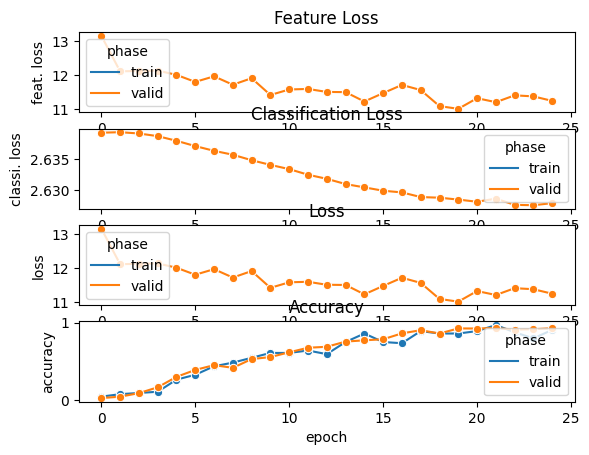

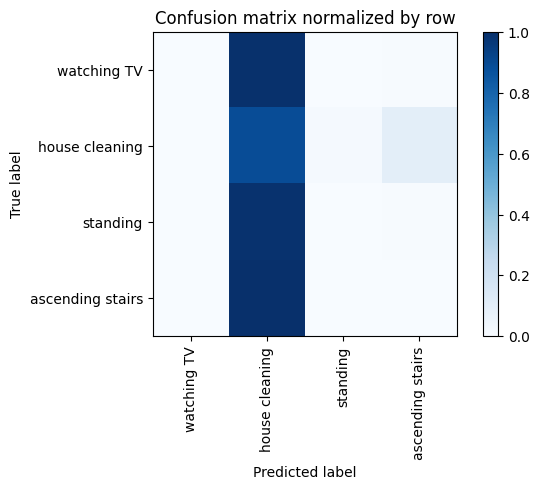

Overall accuracy: 0.299

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  house cleaning       0.311      0.888      0.461      0.336        902|	 ascending stairs: 0.099,	standing: 0.013,	
        standing       0.200      0.003      0.007      0.333        895|	 house cleaning: 0.990,	ascending stairs: 0.007,	
ascending stairs       0.000      0.000      0.000      0.179        480|	 house cleaning: 1.000,	standing: 0.000,	
     watching TV       0.000      0.000      0.000      0.153        411|	 house cleaning: 0.995,	ascending stairs: 0.005,	standing: 0.000,	

----------------------------------------------------------------------------------------------------
     avg / total       0.171      0.299      0.157        1.0       2688|	      

{'accuracy': 0.29910714285714285, 'precision': 0.12773680124223602, 'recall': 0.22284464071151633, 'f1': 0.11680073807733382, 'samples': 2688, 'loss': 0, 'feat. loss': 0, 'classi. loss': 0, 'N': 4}
==

Training Epoch:   4%|▍         | 1/25 [00:05<02:11,  5.46s/it]

Overall accuracy: 0.075



Training Epoch:   8%|▊         | 2/25 [00:10<02:03,  5.37s/it]

Overall accuracy: 0.068



Training Epoch:  12%|█▏        | 3/25 [00:16<01:58,  5.39s/it]

Overall accuracy: 0.071



Training Epoch:  16%|█▌        | 4/25 [00:21<01:53,  5.42s/it]

Overall accuracy: 0.125



Training Epoch:  20%|██        | 5/25 [00:27<01:48,  5.40s/it]

Overall accuracy: 0.297



Training Epoch:  24%|██▍       | 6/25 [00:32<01:42,  5.40s/it]

Overall accuracy: 0.362



Training Epoch:  28%|██▊       | 7/25 [00:37<01:36,  5.36s/it]

Overall accuracy: 0.422



Training Epoch:  32%|███▏      | 8/25 [00:42<01:30,  5.33s/it]

Overall accuracy: 0.420



Training Epoch:  36%|███▌      | 9/25 [00:48<01:25,  5.37s/it]

Overall accuracy: 0.560



Training Epoch:  40%|████      | 10/25 [00:53<01:20,  5.38s/it]

Overall accuracy: 0.556



Training Epoch:  44%|████▍     | 11/25 [00:59<01:15,  5.37s/it]

Overall accuracy: 0.636



Training Epoch:  48%|████▊     | 12/25 [01:04<01:09,  5.35s/it]

Overall accuracy: 0.633



Training Epoch:  52%|█████▏    | 13/25 [01:09<01:04,  5.35s/it]

Overall accuracy: 0.661



Training Epoch:  56%|█████▌    | 14/25 [01:15<00:58,  5.35s/it]

Overall accuracy: 0.667



Training Epoch:  60%|██████    | 15/25 [01:20<00:53,  5.35s/it]

Overall accuracy: 0.671



Training Epoch:  64%|██████▍   | 16/25 [01:25<00:48,  5.36s/it]

Overall accuracy: 0.669



Training Epoch:  68%|██████▊   | 17/25 [01:31<00:43,  5.41s/it]

Overall accuracy: 0.706



Training Epoch:  72%|███████▏  | 18/25 [01:36<00:37,  5.39s/it]

Overall accuracy: 0.701



Training Epoch:  76%|███████▌  | 19/25 [01:42<00:32,  5.41s/it]

Overall accuracy: 0.751



Training Epoch:  80%|████████  | 20/25 [01:47<00:27,  5.48s/it]

Overall accuracy: 0.770



Training Epoch:  84%|████████▍ | 21/25 [01:53<00:21,  5.47s/it]

Overall accuracy: 0.789



Training Epoch:  88%|████████▊ | 22/25 [01:58<00:16,  5.52s/it]

Overall accuracy: 0.824



Training Epoch:  92%|█████████▏| 23/25 [02:03<00:10,  5.33s/it]

Overall accuracy: 0.842



Training Epoch:  96%|█████████▌| 24/25 [02:14<00:06,  6.83s/it]

Overall accuracy: 0.887



seen: 100%|██████████| 15/15 [00:00<00:00, 42.13batch/s, loss=612]


Overall accuracy: 0.885



unseen: 100%|██████████| 41/41 [00:00<00:00, 60.59batch/s]


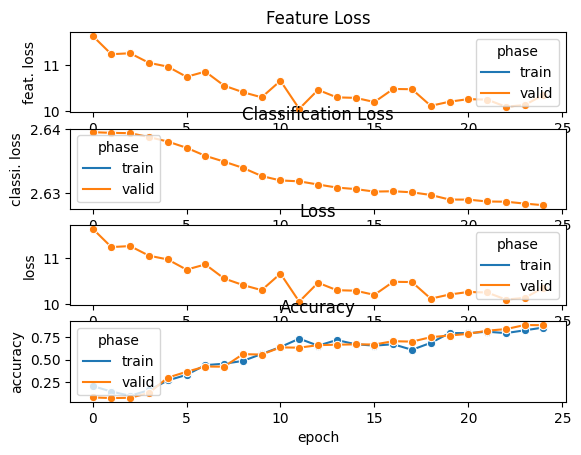

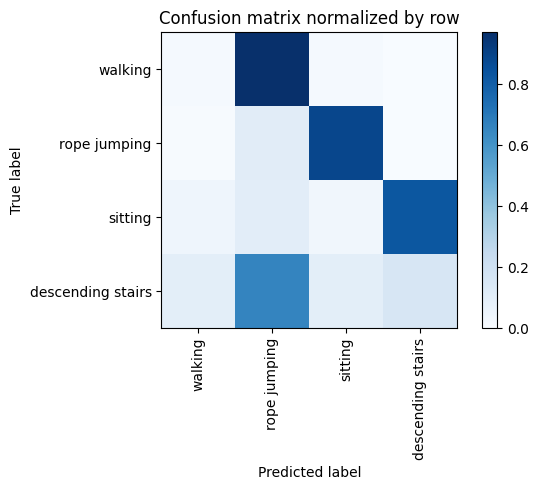

Overall accuracy: 0.050

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.170      0.014      0.026      0.432       1134|	 rope jumping: 0.970,	sitting: 0.014,	
          sitting       0.107      0.033      0.051      0.331        869|	 descending stairs: 0.824,	rope jumping: 0.099,	walking: 0.044,	
descending stairs       0.081      0.153      0.106      0.157        411|	 rope jumping: 0.655,	sitting: 0.097,	
     rope jumping       0.016      0.110      0.027      0.080        210|	 sitting: 0.886,	walking: 0.005,	

----------------------------------------------------------------------------------------------------
      avg / total       0.123      0.050      0.047        1.0       2624|	      

{'accuracy': 0.04992378048780488, 'precision': 0.09336280470427394, 'recall': 0.07757238002471918, 'f1': 0.05247292693124517, 'samples': 2624, 'loss': 0, 'feat. loss': 0, 'classi. loss': 0, 'N': 4}
================ Fold-

Training Epoch:   4%|▍         | 1/25 [00:04<01:49,  4.56s/it]

Overall accuracy: 0.079



Training Epoch:   8%|▊         | 2/25 [00:09<01:44,  4.53s/it]

Overall accuracy: 0.090



Training Epoch:  12%|█▏        | 3/25 [00:13<01:39,  4.51s/it]

Overall accuracy: 0.089



Training Epoch:  16%|█▌        | 4/25 [00:18<01:37,  4.65s/it]

Overall accuracy: 0.094



Training Epoch:  20%|██        | 5/25 [00:23<01:34,  4.71s/it]

Overall accuracy: 0.162



Training Epoch:  24%|██▍       | 6/25 [00:28<01:31,  4.80s/it]

Overall accuracy: 0.215



Training Epoch:  28%|██▊       | 7/25 [00:33<01:28,  4.89s/it]

Overall accuracy: 0.280



Training Epoch:  32%|███▏      | 8/25 [00:38<01:22,  4.86s/it]

Overall accuracy: 0.306



Training Epoch:  36%|███▌      | 9/25 [00:42<01:16,  4.77s/it]

Overall accuracy: 0.308



Training Epoch:  40%|████      | 10/25 [00:47<01:11,  4.80s/it]

Overall accuracy: 0.400



Training Epoch:  44%|████▍     | 11/25 [00:52<01:06,  4.73s/it]

Overall accuracy: 0.407



Training Epoch:  48%|████▊     | 12/25 [00:56<01:01,  4.73s/it]

Overall accuracy: 0.489



Training Epoch:  52%|█████▏    | 13/25 [01:01<00:57,  4.79s/it]

Overall accuracy: 0.545



Training Epoch:  56%|█████▌    | 14/25 [01:06<00:52,  4.74s/it]

Overall accuracy: 0.551



Training Epoch:  60%|██████    | 15/25 [01:11<00:47,  4.77s/it]

Overall accuracy: 0.569



Training Epoch:  64%|██████▍   | 16/25 [01:15<00:42,  4.75s/it]

Overall accuracy: 0.608



Training Epoch:  68%|██████▊   | 17/25 [01:20<00:37,  4.75s/it]

Overall accuracy: 0.663



Training Epoch:  72%|███████▏  | 18/25 [01:25<00:33,  4.77s/it]

Overall accuracy: 0.656



Training Epoch:  76%|███████▌  | 19/25 [01:30<00:29,  4.88s/it]

Overall accuracy: 0.654



Training Epoch:  80%|████████  | 20/25 [01:35<00:25,  5.00s/it]

Overall accuracy: 0.688



Training Epoch:  84%|████████▍ | 21/25 [01:40<00:19,  4.94s/it]

Overall accuracy: 0.734



Training Epoch:  88%|████████▊ | 22/25 [01:45<00:14,  4.84s/it]

Overall accuracy: 0.699



Training Epoch:  92%|█████████▏| 23/25 [01:50<00:09,  4.87s/it]

Overall accuracy: 0.734



Training Epoch:  96%|█████████▌| 24/25 [01:55<00:04,  4.84s/it]

Overall accuracy: 0.689



seen: 100%|██████████| 14/14 [00:00<00:00, 33.71batch/s, loss=643]


Overall accuracy: 0.743



unseen: 100%|██████████| 54/54 [00:01<00:00, 50.41batch/s]


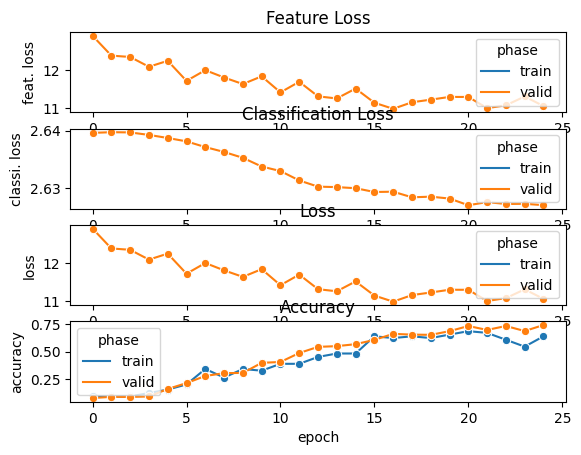

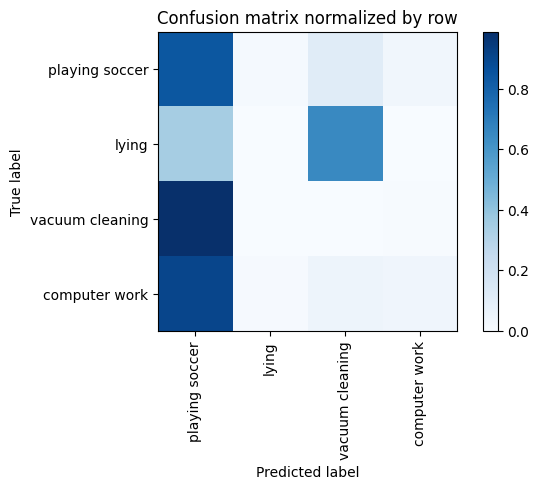

Overall accuracy: 0.070

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.808      0.039      0.075      0.437       1509|	 playing soccer: 0.906,	vacuum cleaning: 0.047,	
          lying       0.000      0.000      0.000      0.263        908|	 vacuum cleaning: 0.651,	playing soccer: 0.347,	computer work: 0.002,	
vacuum cleaning       0.003      0.002      0.003      0.238        822|	 playing soccer: 0.988,	computer work: 0.006,	lying: 0.004,	
 playing soccer       0.068      0.839      0.126      0.063        217|	 vacuum cleaning: 0.115,	computer work: 0.032,	

----------------------------------------------------------------------------------------------------
    avg / total       0.358      0.070      0.041        1.0       3456|	      

{'accuracy': 0.0703125, 'precision': 0.21978347346210447, 'recall': 0.22006037708292275, 'f1': 0.05076433206867895, 'samples': 3456, 'loss': 0, 'feat. loss': 0, 'classi. loss': 0, 

Training Epoch:   4%|▍         | 1/25 [00:05<02:08,  5.34s/it]

Overall accuracy: 0.104



Training Epoch:   8%|▊         | 2/25 [00:10<02:02,  5.31s/it]

Overall accuracy: 0.105



Training Epoch:  12%|█▏        | 3/25 [00:16<01:59,  5.43s/it]

Overall accuracy: 0.104



Training Epoch:  16%|█▌        | 4/25 [00:21<01:51,  5.30s/it]

Overall accuracy: 0.168



Training Epoch:  20%|██        | 5/25 [00:26<01:45,  5.26s/it]

Overall accuracy: 0.302



Training Epoch:  24%|██▍       | 6/25 [00:32<01:42,  5.37s/it]

Overall accuracy: 0.419



Training Epoch:  28%|██▊       | 7/25 [00:37<01:38,  5.48s/it]

Overall accuracy: 0.457



Training Epoch:  32%|███▏      | 8/25 [00:43<01:32,  5.44s/it]

Overall accuracy: 0.454



Training Epoch:  36%|███▌      | 9/25 [00:48<01:26,  5.39s/it]

Overall accuracy: 0.501



Training Epoch:  40%|████      | 10/25 [00:53<01:20,  5.37s/it]

Overall accuracy: 0.523



Training Epoch:  44%|████▍     | 11/25 [00:59<01:16,  5.49s/it]

Overall accuracy: 0.531



Training Epoch:  48%|████▊     | 12/25 [01:04<01:10,  5.41s/it]

Overall accuracy: 0.569



Training Epoch:  52%|█████▏    | 13/25 [01:10<01:04,  5.38s/it]

Overall accuracy: 0.582



Training Epoch:  56%|█████▌    | 14/25 [01:15<00:58,  5.34s/it]

Overall accuracy: 0.597



Training Epoch:  60%|██████    | 15/25 [01:20<00:53,  5.33s/it]

Overall accuracy: 0.630



Training Epoch:  64%|██████▍   | 16/25 [01:25<00:47,  5.27s/it]

Overall accuracy: 0.661



Training Epoch:  68%|██████▊   | 17/25 [01:31<00:42,  5.27s/it]

Overall accuracy: 0.666



Training Epoch:  72%|███████▏  | 18/25 [01:36<00:37,  5.29s/it]

Overall accuracy: 0.683



Training Epoch:  76%|███████▌  | 19/25 [01:41<00:32,  5.37s/it]

Overall accuracy: 0.714



Training Epoch:  80%|████████  | 20/25 [01:47<00:26,  5.34s/it]

Overall accuracy: 0.752



Training Epoch:  84%|████████▍ | 21/25 [01:52<00:21,  5.44s/it]

Overall accuracy: 0.711



Training Epoch:  88%|████████▊ | 22/25 [01:58<00:16,  5.65s/it]

Overall accuracy: 0.771



Training Epoch:  92%|█████████▏| 23/25 [02:04<00:11,  5.59s/it]

Overall accuracy: 0.737



Training Epoch:  96%|█████████▌| 24/25 [02:10<00:05,  5.61s/it]

Overall accuracy: 0.777



seen: 100%|██████████| 16/16 [00:00<00:00, 44.57batch/s, loss=619]


Overall accuracy: 0.794



unseen: 100%|██████████| 33/33 [00:00<00:00, 50.83batch/s]


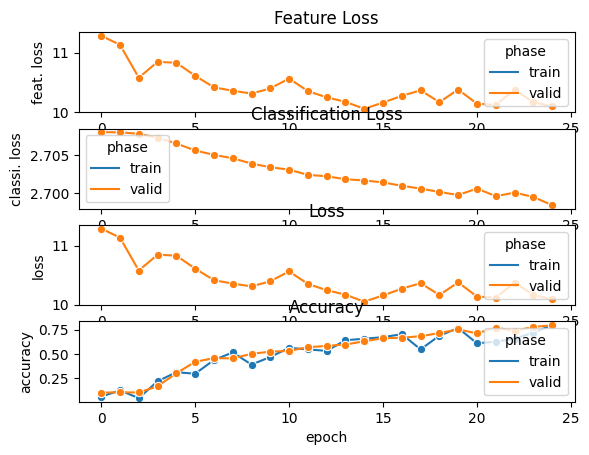

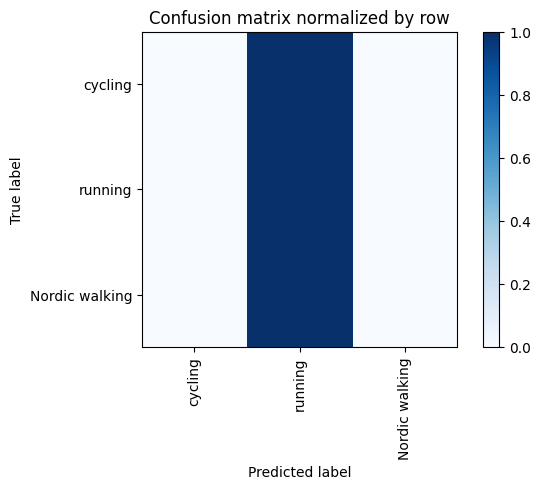

Overall accuracy: 0.214

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.000      0.000      0.000      0.420        887|	 running: 1.000,	cycling: 0.000,	
       cycling       1.000      0.001      0.003      0.366        773|	 running: 0.999,	Nordic walking: 0.000,	
       running       0.214      1.000      0.353      0.214        452|	 Nordic walking: 0.000,	cycling: 0.000,	

----------------------------------------------------------------------------------------------------
   avg / total       0.412      0.214      0.076        1.0       2112|	      

{'accuracy': 0.21448863636363635, 'precision': 0.4047055108163588, 'recall': 0.33376455368693403, 'f1': 0.11843188178151748, 'samples': 2112, 'loss': 0, 'feat. loss': 0, 'classi. loss': 0, 'N': 3}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
seen classes >  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 15, 16, 17]
un

Training Epoch:   4%|▍         | 1/25 [00:05<02:21,  5.89s/it]

Overall accuracy: 0.078



Training Epoch:   8%|▊         | 2/25 [00:11<02:13,  5.80s/it]

Overall accuracy: 0.079



Training Epoch:  12%|█▏        | 3/25 [00:17<02:08,  5.84s/it]

Overall accuracy: 0.079



Training Epoch:  16%|█▌        | 4/25 [00:23<02:01,  5.78s/it]

Overall accuracy: 0.115



Training Epoch:  20%|██        | 5/25 [00:29<01:58,  5.92s/it]

Overall accuracy: 0.152



Training Epoch:  24%|██▍       | 6/25 [00:35<01:53,  6.00s/it]

Overall accuracy: 0.188



Training Epoch:  28%|██▊       | 7/25 [00:41<01:47,  5.95s/it]

Overall accuracy: 0.315



Training Epoch:  32%|███▏      | 8/25 [00:47<01:40,  5.92s/it]

Overall accuracy: 0.404



Training Epoch:  36%|███▌      | 9/25 [00:53<01:34,  5.88s/it]

Overall accuracy: 0.514



Training Epoch:  40%|████      | 10/25 [00:59<01:29,  5.95s/it]

Overall accuracy: 0.558



Training Epoch:  44%|████▍     | 11/25 [01:04<01:22,  5.91s/it]

Overall accuracy: 0.608



Training Epoch:  48%|████▊     | 12/25 [01:10<01:15,  5.83s/it]

Overall accuracy: 0.642



Training Epoch:  52%|█████▏    | 13/25 [01:15<01:07,  5.67s/it]

Overall accuracy: 0.647



Training Epoch:  56%|█████▌    | 14/25 [01:21<01:01,  5.60s/it]

Overall accuracy: 0.665



Training Epoch:  60%|██████    | 15/25 [01:26<00:55,  5.60s/it]

Overall accuracy: 0.655



Training Epoch:  64%|██████▍   | 16/25 [01:32<00:50,  5.61s/it]

Overall accuracy: 0.681



Training Epoch:  68%|██████▊   | 17/25 [01:38<00:45,  5.63s/it]

Overall accuracy: 0.676



Training Epoch:  72%|███████▏  | 18/25 [01:43<00:39,  5.58s/it]

Overall accuracy: 0.678



Training Epoch:  76%|███████▌  | 19/25 [01:49<00:33,  5.57s/it]

Overall accuracy: 0.691



Training Epoch:  80%|████████  | 20/25 [01:54<00:27,  5.56s/it]

Overall accuracy: 0.686



Training Epoch:  84%|████████▍ | 21/25 [02:00<00:21,  5.48s/it]

Overall accuracy: 0.722



Training Epoch:  88%|████████▊ | 22/25 [02:06<00:17,  5.81s/it]

Overall accuracy: 0.718



Training Epoch:  92%|█████████▏| 23/25 [02:12<00:11,  5.89s/it]

Overall accuracy: 0.719



Training Epoch:  96%|█████████▌| 24/25 [02:18<00:05,  5.85s/it]

Overall accuracy: 0.744



seen: 100%|██████████| 17/17 [00:00<00:00, 44.16batch/s, loss=686]


Overall accuracy: 0.746



unseen: 100%|██████████| 29/29 [00:00<00:00, 59.58batch/s]


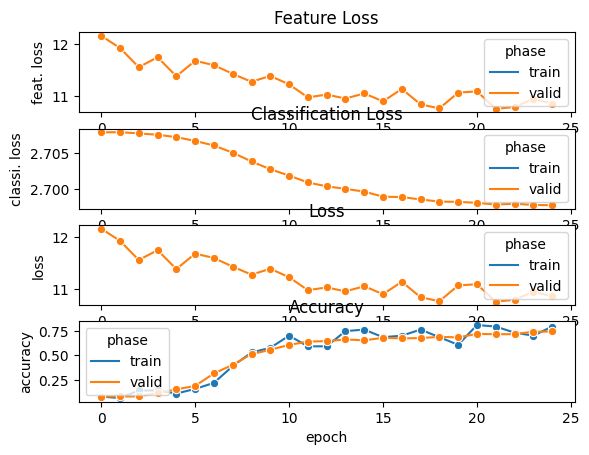

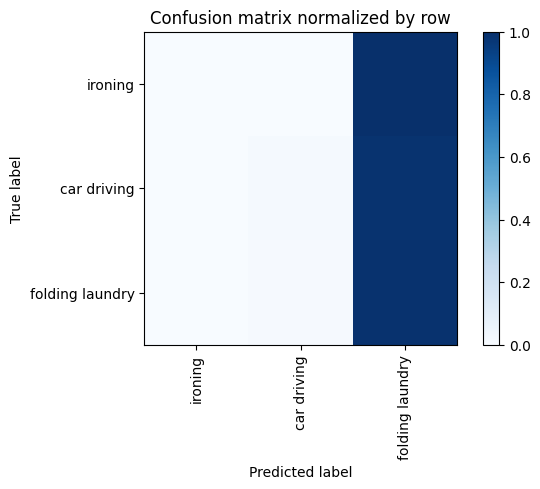

Overall accuracy: 0.252

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.000      0.000      0.000      0.608       1128|	 folding laundry: 1.000,	car driving: 0.000,	
folding laundry       0.251      0.991      0.400      0.252        467|	 car driving: 0.009,	ironing: 0.000,	
    car driving       0.500      0.015      0.030      0.141        261|	 folding laundry: 0.985,	ironing: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.133      0.252      0.105        1.0       1856|	      

{'accuracy': 0.2516163793103448, 'precision': 0.2501803751803752, 'recall': 0.3355867866685263, 'f1': 0.1432465923172243, 'samples': 1856, 'loss': 0, 'feat. loss': 0, 'classi. loss': 0, 'N': 3}
============== Overall Unseen Classes Performance ==============
accuracy     0.170872
precision    0.207122
recall       0.227220
f1           0.092510
dtype: fl

NameError: name 'run' is not defined

In [50]:
# run['parameters'] = config
fold_metric_scores = []

for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=12, window_overlap=10, resample_freq=50)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=skel_actions, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=skel_actions, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=skel_actions, attribute_dict=action_dict, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    imu_config = {
        'in_ft':in_ft, 
        'd_model':config['d_model'], 
        'num_heads':config['num_heads'], 
        'ft_size':config['feat_size'], 
        'max_len':seq_len, 
        'n_classes':len(seen_classes)
    }
    model = IMUEncoder(**imu_config)
    model.to(device)

    seen_action_ft, seen_action_label = gen_semantic_space(action_dict, seen_classes, skel_actions)
    unseen_action_ft, unseen_action_label = gen_semantic_space(action_dict, unseen_classes, skel_actions)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-6)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
    
        train_metrics = train_step(model, train_dl, train_dt, optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.0001)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        # log(i, 'train', train_metrics)

        eval_metrics = eval_step(model, eval_dl, eval_dt, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', loss_alpha=0.0001, print_report=False, show_plot=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        # log(i, 'eval', eval_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    model.load_state_dict(best_model)
    # save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics, a,b,c,d,e = unseen_eval_step(model, test_dl, unseen_action_ft, unseen_action_label, loss_module, device, class_names=[all_classes[i] for i in unseen_classes], class_ids=unseen_classes, phase='unseen', loss_alpha=config['imu_alpha'], print_report=True, show_plot=True, neighs=config['neighs'])
    # over_plot_preds(a,b,c,d,e)
    # over_plot_preds(a,b,c[:30, :],d[:30],e)
    test_metrics['N'] = len(unseen_classes)
    fold_metric_scores.append(test_metrics)
    # log('test', i, test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
weighted_score_df = seen_score_df[["accuracy", "precision", "recall", "f1"]].multiply(seen_score_df["N"], axis="index")
final_results = weighted_score_df.sum()/seen_score_df['N'].sum()
print(final_results)
# log('global', '',final_results.to_dict())
# run.stop()
